### Par Sensitivities of a Swap

In this notebook we are trying to calculate par sensitivities of a swap compared to zero rate sensitivities.
We will do this with an OIS and an 6M Euribor fixed float swap.

How we are building up the curves has been explored in further detail in the OIS Bootstrap and EURIBOR Bootstrap notebooks.

In [1]:
# initiating
from typing import List

import QuantLib as ql

today = ql.Date(10, ql.May, 2019)
ql.Settings.instance().evaluationDate = today

The OIS curve is built from and a couple of overnight indexed swaps. We do not include the money market quote because according to ISDA-SIMM the first sensitivity should be against the 2W quote and we would need to remap sensitivities against the fixing to this 2W quote if we did include it.

In [2]:
# OIS Par Quotes used as input

ois_quotes = {ql.Period(2, ql.Weeks): ql.SimpleQuote(-0.36503/100),
               ql.Period(1, ql.Months): ql.SimpleQuote(-0.3650/100),
               ql.Period(3, ql.Months): ql.SimpleQuote(-0.36521/100),
               ql.Period(6, ql.Months): ql.SimpleQuote(-0.36754/100),
               ql.Period(1, ql.Years): ql.SimpleQuote(-0.37488/100),
               ql.Period(2, ql.Years): ql.SimpleQuote(-0.36102/100),
               ql.Period(3, ql.Years): ql.SimpleQuote(-0.31511/100),
               ql.Period(5, ql.Years): ql.SimpleQuote(-0.17438/100),
               ql.Period(10, ql.Years): ql.SimpleQuote(0.28879/100),
               ql.Period(15, ql.Years): ql.SimpleQuote(0.62908/100),
               ql.Period(20, ql.Years): ql.SimpleQuote(0.82255/100),
               ql.Period(30, ql.Years): ql.SimpleQuote(0.92238/100)}

In [3]:
eonia_index = ql.Eonia()

ois_helpers = []

#create and add the OISs from the quotes
for tenor, quote in ois_quotes.items():
    ois_helpers.append(ql.OISRateHelper(2, tenor, ql.QuoteHandle(quote), eonia_index))

eonia_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), ois_helpers, ql.Actual360())
eonia_curve.enableExtrapolation()

The EURIBOR 6M curve is built from today's 6M fixing and a couple of fixed float swap quotes.

In [4]:
euribor_money_market = ql.SimpleQuote(-0.231/100)

euribor_helpers = []

euribor_helpers += [ql.DepositRateHelper(ql.QuoteHandle(euribor_money_market), ql.Period(6, ql.Months),2, ql.TARGET(), ql.ModifiedFollowing, False, ql.Actual360())]

euribor_swap_quotes = {ql.Period(1, ql.Years): ql.SimpleQuote(-0.2355/100),
                  ql.Period(2, ql.Years): ql.SimpleQuote(-0.20860/100),
                  ql.Period(3, ql.Years): ql.SimpleQuote(-0.1525/100),
                  ql.Period(5, ql.Years): ql.SimpleQuote(-0.17438/100),
                  ql.Period(10, ql.Years): ql.SimpleQuote(0.28879/100),
                  ql.Period(15, ql.Years): ql.SimpleQuote(0.62908/100),
                  ql.Period(20, ql.Years): ql.SimpleQuote(0.82255/100),
                  ql.Period(30, ql.Years): ql.SimpleQuote(0.92238/100)}

In [5]:
for tenor, quote in euribor_swap_quotes.items():
    euribor_helpers.append(ql.SwapRateHelper(ql.QuoteHandle(quote),
                                             tenor,
                                             ql.TARGET(),
                                             ql.Annual,
                                             ql.Following,
                                             ql.Actual360(),
                                             ql.Euribor6M(),
                                             ql.QuoteHandle(),
                                             ql.Period(0, ql.Days),
                                             ql.YieldTermStructureHandle(eonia_curve)))

In [6]:
euribor6m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), euribor_helpers, ql.Actual360())
euribor6m_curve.enableExtrapolation()

In [7]:
pricing_engine_eonia = ql.DiscountingSwapEngine(ql.YieldTermStructureHandle(eonia_curve))
pricing_engine_euribor_6m = ql.DiscountingSwapEngine(ql.YieldTermStructureHandle(euribor6m_curve))

Finally, we need to reinitate our two Indexes with their newly created term structures.

In [8]:
eonia_index = ql.Eonia(ql.YieldTermStructureHandle(eonia_curve))
euribor6m_index = ql.Euribor6M(ql.YieldTermStructureHandle(euribor6m_curve))

We can plot the two created curves.

First the forward and zero curve for EONIA:

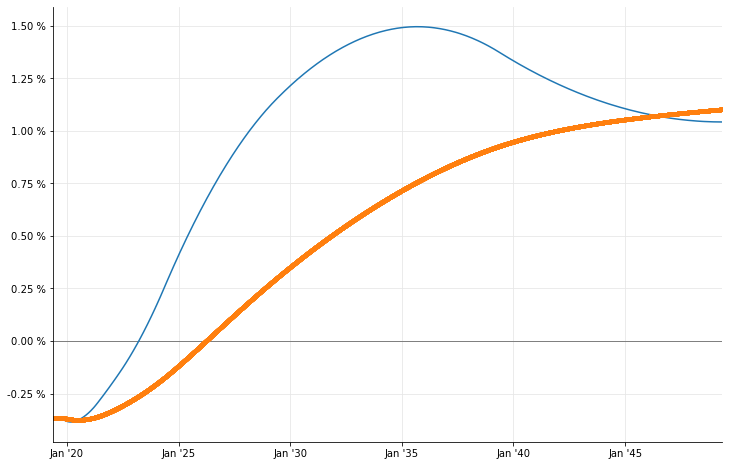

In [9]:
from quantlibpythoncookbook_extras import utils

end= today+ql.Period(30, ql.Years)
dates= [ql.Date(serial) for serial in range(ql.TARGET().advance(today, 2, ql.Days).serialNumber(), end.serialNumber()+1)]
forward_rates = [eonia_curve.forwardRate(d, ql.TARGET().advance(d,1,ql.Days), ql.Actual360(), ql.Simple).rate() for d in dates]
zero_rates = [eonia_curve.zeroRate(d, ql.Actual360(), ql.Simple).rate() for d in dates]

_, ax = utils.plot()
utils.highlight_x_axis(ax)
utils.plot_curve(ax, dates, [(forward_rates, '-')], format_rates=True)
utils.plot_curve(ax, dates, [(zero_rates, '.')], format_rates=True)

Now the 6M forward and zero curve for the 6M EURIBOR:

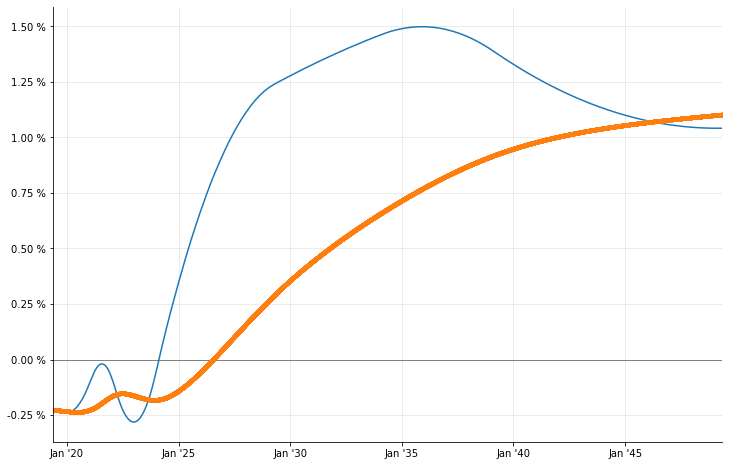

In [10]:
forward_rates = [euribor6m_curve.forwardRate(d, ql.TARGET().advance(d,6,ql.Months), ql.Actual360(), ql.Simple).rate() for d in dates]
zero_rates = [euribor6m_curve.zeroRate(d, ql.Actual360(), ql.Simple).rate() for d in dates]

_, ax = utils.plot()
utils.highlight_x_axis(ax)
utils.plot_curve(ax, dates, [(forward_rates, '-')], format_rates=True)
utils.plot_curve(ax, dates, [(zero_rates, '.')], format_rates=True)

Now we create a 2-year Eonia fixed float OIS and a 3-year Euribor 6M fixed float swap. Our goal is to check what happens to the price of these trades, when we bump our input quotes.

In [11]:
# Creation of test OIS

nominal = 100
fixedRate = 0.00
dc = ql.Actual360()
type = ql.OvernightIndexedSwap.Payer
test_schedule = ql.Schedule (ql.TARGET().advance(today, 2, ql.Days), ql.Date(14, ql.May, 2021), ql.Period(1, ql.Years), ql.TARGET(), ql.ModifiedFollowing, ql.ModifiedFollowing, ql.DateGeneration.Forward, False)
test_ois = ql.OvernightIndexedSwap(type, nominal, test_schedule, fixedRate, dc, eonia_index)

test_ois.setPricingEngine(pricing_engine_eonia)

print(test_ois.fairRate())
print(test_ois.NPV())

-0.003610200000089769
-0.7371737070217497


In [12]:
# Creation of test Euribor 6M Swap

nominal = 100
fixedRate = 0
dc = ql.Actual360()
type = ql.VanillaSwap.Payer
index = ql.Euribor6M(ql.YieldTermStructureHandle(euribor6m_curve))
float_schedule = ql.Schedule(ql.TARGET().advance(today, 2, ql.Days), ql.Date(16, ql.May, 2022), ql.Period(6, ql.Months), ql.TARGET(), ql.ModifiedFollowing, ql.ModifiedFollowing, ql.DateGeneration.Forward, False)
fixed_schedule = ql.Schedule(ql.TARGET().advance(today, 2, ql.Days), ql.Date(16, ql.May, 2022), ql.Period(1, ql.Years), ql.TARGET(), ql.ModifiedFollowing, ql.ModifiedFollowing, ql.DateGeneration.Forward, False)

test_swap = ql.VanillaSwap(type, nominal, fixed_schedule, fixedRate, ql.Actual360(), float_schedule, index, 0, ql.Actual360())

test_swap.setPricingEngine(pricing_engine_euribor_6m)

print(test_swap.fairRate())
print(test_swap.NPV())

-0.0015268201208136834
-0.46743863530860486


For convenience we create a quick finite difference sensitivity calculation utility function.

In [13]:
def fd_simple_quotes(quotes: List[ql.SimpleQuote], instrument):
    abs_bump = 0.000025
    p0 = instrument.NPV()
    origVals = []
    for quote in quotes:
        origVals.append(quote.value())
        quote.setValue(quote.value()+abs_bump)
    p1 = instrument.NPV()
    finite_difference = (p1-p0)/abs_bump
    origVals.reverse()
    for quote in quotes:
        quote.setValue(origVals.pop())
    return finite_difference

Now we calculate the par sensitivities of our OIS swap.

In [14]:
for period, quote in ois_quotes.items():
    delta = fd_simple_quotes([quote], test_ois)
    print('OIS %s par sensitivity of the OIS is %.4f.' % (period.__str__(), delta))

OIS 2W par sensitivity of the OIS is 0.0000.
OIS 1M par sensitivity of the OIS is 0.0000.
OIS 3M par sensitivity of the OIS is 0.0000.
OIS 6M par sensitivity of the OIS is 0.0000.
OIS 1Y par sensitivity of the OIS is 0.3774.
OIS 2Y par sensitivity of the OIS is 204.9369.
OIS 3Y par sensitivity of the OIS is 0.0000.
OIS 5Y par sensitivity of the OIS is 0.0000.
OIS 10Y par sensitivity of the OIS is 0.0000.
OIS 15Y par sensitivity of the OIS is 0.0000.
OIS 20Y par sensitivity of the OIS is 0.0000.
OIS 30Y par sensitivity of the OIS is 0.0000.


New let's calculate sensitivities to the OIS curve of our EURIBOR 6M Swap

In [15]:
for period, quote in ois_quotes.items():
    delta = fd_simple_quotes([quote], test_swap)
    print('OIS %s par sensitivty of the EURIBOR 6M swap is %.4f.' % (period.__str__(),delta))

OIS 2W par sensitivty of the EURIBOR 6M swap is -0.0007.
OIS 1M par sensitivty of the EURIBOR 6M swap is 0.0023.
OIS 3M par sensitivty of the EURIBOR 6M swap is -0.0085.
OIS 6M par sensitivty of the EURIBOR 6M swap is -0.0333.
OIS 1Y par sensitivty of the EURIBOR 6M swap is -0.0569.
OIS 2Y par sensitivty of the EURIBOR 6M swap is 0.0222.
OIS 3Y par sensitivty of the EURIBOR 6M swap is 0.4053.
OIS 5Y par sensitivty of the EURIBOR 6M swap is -0.0018.
OIS 10Y par sensitivty of the EURIBOR 6M swap is 0.0003.
OIS 15Y par sensitivty of the EURIBOR 6M swap is -0.0001.
OIS 20Y par sensitivty of the EURIBOR 6M swap is 0.0000.
OIS 30Y par sensitivty of the EURIBOR 6M swap is -0.0000.


Now let's calculate sensitivities to the EURIBOR 6M Swap of our EURIBOR 6M Swap

In [16]:
delta = fd_simple_quotes([euribor_money_market], test_swap)
print('EURIBOR 6M 6M par sensitivity of the EURIBOR 6M swap is %.4f.' % delta)
for period, quote in euribor_swap_quotes.items():
    delta = fd_simple_quotes([quote], test_swap)
    print('EURIBOR 6M %s par sensitivty of the EURIBOR 6M swap is %.4f.' % (period.__str__(),delta))

EURIBOR 6M 6M par sensitivity of the EURIBOR 6M swap is 0.0678.
EURIBOR 6M 1Y par sensitivty of the EURIBOR 6M swap is 0.3483.
EURIBOR 6M 2Y par sensitivty of the EURIBOR 6M swap is 0.7254.
EURIBOR 6M 3Y par sensitivty of the EURIBOR 6M swap is 305.7009.
EURIBOR 6M 5Y par sensitivty of the EURIBOR 6M swap is -0.0058.
EURIBOR 6M 10Y par sensitivty of the EURIBOR 6M swap is 0.0009.
EURIBOR 6M 15Y par sensitivty of the EURIBOR 6M swap is -0.0004.
EURIBOR 6M 20Y par sensitivty of the EURIBOR 6M swap is 0.0001.
EURIBOR 6M 30Y par sensitivty of the EURIBOR 6M swap is -0.0000.


Checking if payment schedule aligns

In [17]:
reference_ois = ois_helpers[6].swap()
for cashflow in reference_ois.overnightLeg():
    print(cashflow.date())
for cashflow in test_ois.overnightLeg():
    print(cashflow.date())

May 14th, 2020
May 14th, 2021
May 16th, 2022
May 14th, 2020
May 14th, 2021


In [18]:
reference_swap = euribor_helpers[3].swap()
for cashflow in reference_swap.floatingLeg():
    print(cashflow.date())
for cashflow in test_swap.floatingLeg():
    print(cashflow.date())



November 14th, 2019
May 14th, 2020
November 16th, 2020
May 14th, 2021
November 15th, 2021
May 16th, 2022
November 14th, 2019
May 14th, 2020
November 16th, 2020
May 14th, 2021
November 15th, 2021
May 16th, 2022
